In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
df = pd.read_csv('weather_data.csv')

In [3]:
df = pd.DataFrame(df)

In [4]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2024-10-22 00:00,26.1,7.9,179,29.86,0.0,74,35,0.0,1003
1,2024-10-22 01:00,26.0,7.2,188,29.85,0.0,74,32,0.0,1003
2,2024-10-22 02:00,25.8,6.1,185,29.84,0.0,73,26,0.0,1003
3,2024-10-22 03:00,25.5,6.5,168,29.84,0.0,73,34,0.0,1003
4,2024-10-22 04:00,25.5,6.1,183,29.85,0.0,72,20,0.0,1000


In [5]:
df.duplicated().sum()

0

In [6]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [7]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.1,7.9,179,29.86,74,35
1,26.0,7.2,188,29.85,74,32
2,25.8,6.1,185,29.84,73,26
3,25.5,6.5,168,29.84,73,34
4,25.5,6.1,183,29.85,72,20


In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training)

In [9]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# train_scaled = scaler.fit_transform(training)

In [10]:
pd.DataFrame(train_scaled).head(5)

,0,1,2,3,4,5
0,0.272,0.378788,0.500000,0.807692,0.637931,0.35
1,0.264,0.343434,0.525140,0.769231,0.637931,0.32
2,0.248,0.287879,0.516760,0.730769,0.620690,0.26
3,0.224,0.308081,0.469274,0.730769,0.620690,0.34
4,0.224,0.287879,0.511173,0.769231,0.603448,0.20


In [11]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [12]:
sequence_length = 6
forecast_horizon = 1

X, y = create_sequences(train_scaled, sequence_length, forecast_horizon)

In [13]:
split_ratio = 0.8
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [47]:
num_features = X.shape[2]

# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(sequence_length, num_features)),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, activation='tanh', return_sequences=True)),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, activation='tanh', return_sequences=True)),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, activation='tanh', return_sequences=True)),
#     tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, activation='tanh', return_sequences=False)),
#     tf.keras.layers.BatchNormalization(),
#     # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='tanh', return_sequences=False)),
#     # tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(256, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(128, activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(64, activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     # tf.keras.layers.Dense(32, activation='relu'),
#     # tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(num_features * forecast_horizon),
#     tf.keras.layers.Reshape((forecast_horizon, num_features))
# ])

model = tf.keras.Sequential([    
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, activation='tanh', return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, activation='tanh', return_sequences=False)),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, activation='tanh', return_sequences=False)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    # tf.keras.layers.Dropout(0.2),
    # tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    # tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_features * forecast_horizon),  
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mae', metrics=['mae'])

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_6 (Bidirectio  (None, 6, 512)           405504    
 nal)                                                            
                                                                 
 batch_normalization_6 (Batc  (None, 6, 512)           2048      
 hNormalization)                                                 
                                                                 
 bidirectional_7 (Bidirectio  (None, 256)              493056    
 nal)                                                            
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 256)              

In [49]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_mae', factor = 0.5, patience=4, min_lr=1e-6)

In [50]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['mae'] <= 0.060 and logs['val_mae'] <= 0.060:
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

In [51]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[custom_early_stopping])
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr])

Epoch 1/100
38/38 [==============================] - 9s 103ms/step - loss: 2.8350 - mae: 0.3926 - val_loss: 2.6091 - val_mae: 0.3412
Epoch 2/100
38/38 [==============================] - 1s 28ms/step - loss: 2.3364 - mae: 0.2346 - val_loss: 2.2741 - val_mae: 0.3384
Epoch 3/100
38/38 [==============================] - 1s 27ms/step - loss: 1.9899 - mae: 0.1958 - val_loss: 1.9987 - val_mae: 0.3459
Epoch 4/100
38/38 [==============================] - 1s 27ms/step - loss: 1.6953 - mae: 0.1627 - val_loss: 1.7644 - val_mae: 0.3517
Epoch 5/100
38/38 [==============================] - 1s 26ms/step - loss: 1.4474 - mae: 0.1373 - val_loss: 1.5540 - val_mae: 0.3462
Epoch 6/100
38/38 [==============================] - 1s 26ms/step - loss: 1.2519 - mae: 0.1315 - val_loss: 1.3613 - val_mae: 0.3282
Epoch 7/100
38/38 [==============================] - 1s 28ms/step - loss: 1.0807 - mae: 0.1219 - val_loss: 1.1939 - val_mae: 0.3097
Epoch 8/100
38/38 [==============================] - 1s 27ms/step - loss: 0

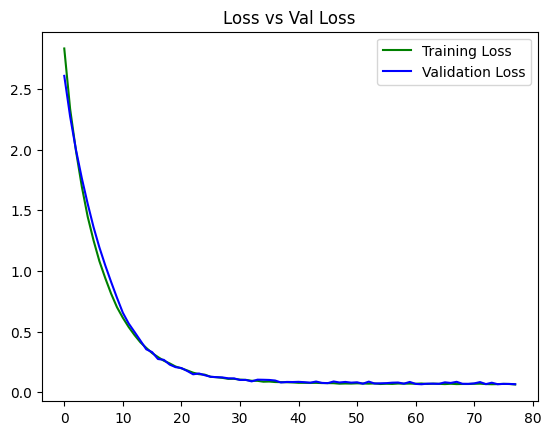

In [52]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

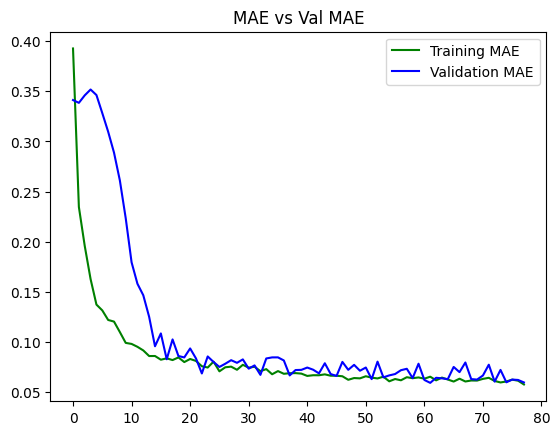

In [53]:
plt.plot(history.history['mae'], color='g', label='Training MAE')
plt.plot(history.history['val_mae'], color='b', label='Validation MAE')
plt.title("MAE vs Val MAE")
plt.legend()
plt.show()

In [54]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}".format(loss, mae))

Loss : 0.06588470190763474, MAE : 0.05963347479701042


In [58]:
predictions = model.predict(x_test)

print(scaler.inverse_transform(predictions[2]))
print(scaler.inverse_transform(y_test[2]))

5/5 [==============================] - 0s 9ms/step
[[30.640682 10.200598 49.979576 29.69349  61.994816 82.90178 ]]
[[30.2  12.6  35.   29.69 64.   80.  ]]


In [59]:
# model.save('forecasting.h5')